# Visualiser for area28 metric data

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data as CSV / json file

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df.tail()

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1327,CORE_SCENE_LEAVE,8,74,1,2021-11-16 15:57:39,"{'rating': None, 'rating_cat': None}"
1328,CORE_SCENE_RATE,8,74,1,2021-11-16 15:59:14,"{'rating': 0, 'rating_cat': 'Chat'}"
1329,CORE_SCENE_JOIN,9,74,1,2021-11-16 11:21:51,"{'rating': None, 'rating_cat': None}"
1330,CORE_SCENE_LEAVE,9,74,1,2021-11-16 13:30:13,"{'rating': None, 'rating_cat': None}"
1331,CORE_SCENE_RATE,9,74,1,2021-11-16 13:31:08,"{'rating': 3, 'rating_cat': 'Cat5'}"


## Pre-process data to be visualised

In [4]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId', 'sessionId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]
df_no_rating['week_number'] = [d.isocalendar()[1] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'sessionId', 'date', 'duration', 'time', 'weekday', 'week_number', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed.tail()

,userId,sessionId,date,duration,time,weekday,week_number,sceneId
id,,,,,,,,
1320,5,74,2021-11-16,0 days 04:00:36,14:08:25,Tuesday,46,1
1322,6,74,2021-11-16,0 days 03:17:34,13:08:24,Tuesday,46,1
1325,7,74,2021-11-16,0 days 00:35:26,11:17:55,Tuesday,46,1
1327,8,74,2021-11-16,0 days 01:58:47,15:57:39,Tuesday,46,1
1330,9,74,2021-11-16,0 days 02:08:22,13:30:13,Tuesday,46,1


In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

import ipywidgets as widgets
from IPython.display import display

In [6]:
dropdown_timeframe = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler(change):
    common_filtering(change.new, dropdown_user.value)

def dropdown_user_eventhandler(change):
    common_filtering(dropdown_timeframe.value, change.new)
    
def common_filtering(timeframe, user):
    output_widget.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget:
        display(df_processed_user_timeframed)

dropdown_timeframe.observe(dropdown_timeframe_eventhandler, names='value')
dropdown_user.observe(dropdown_user_eventhandler, names='value')
display(dropdown_timeframe)
display(dropdown_user)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

In [7]:
display(output_widget)

Output()

## Activity heatmap

In [8]:
from pandas import DataFrame
import seaborn as sns
import time

In [9]:
dropdown_timeframe_hm = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_hm = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_heatmap_widget = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_hm(change):
    common_filtering_hm(change.new, dropdown_user_hm.value)

def dropdown_user_eventhandler_hm(change):
    common_filtering_hm(dropdown_timeframe_hm.value, change.new)
    
def common_filtering_hm(timeframe, user):
    output_heatmap_widget.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_heatmap_widget:
        df_processed_user_timeframed['seconds'] = [d.total_seconds() for d in df_processed_user_timeframed['duration']]
        df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed_user_timeframed.groupby(['week_number', 'weekday'])['seconds'].sum()}).reset_index()
        df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='week_number', values='seconds')
        df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
        df_heatmap.sort_index(level=0, inplace=True)

        mask = df_heatmap.isnull()
        sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest', mask=mask)
        plt.show()

dropdown_timeframe_hm.observe(dropdown_timeframe_eventhandler_hm, names='value')
dropdown_user_hm.observe(dropdown_user_eventhandler_hm, names='value')
display(dropdown_timeframe_hm)
display(dropdown_user_hm)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

In [10]:
display(output_heatmap_widget)

Output()

# Pie chart of time spent in different scenes

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

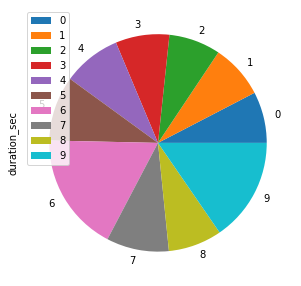

In [11]:
dropdown_timeframe_timespent = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_timespent = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_timespent = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_timespent(change):
    common_filtering_timespent(change.new, dropdown_user_timespent.value)

def dropdown_user_eventhandler_timespent(change):
    common_filtering_timespent(dropdown_timeframe_timespent.value, change.new)
    
def common_filtering_timespent(timeframe, user):
    output_widget_timespent.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_timespent:
        df_sessions = pd.DataFrame({'duration' : df_processed_user_timeframed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
        df_sessions['duration_sec'] = [d.total_seconds() for d in df_sessions['duration']]
        plot = df_sessions.plot.pie(y='duration_sec', figsize=(5, 5))

dropdown_timeframe_timespent.observe(dropdown_timeframe_eventhandler_timespent, names='value')
dropdown_user_timespent.observe(dropdown_user_eventhandler_timespent, names='value')
display(dropdown_timeframe_timespent)
display(dropdown_user_timespent)

In [12]:
display(output_widget_timespent)

Output()

### Bar Chart showing how long users spent in sessions

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

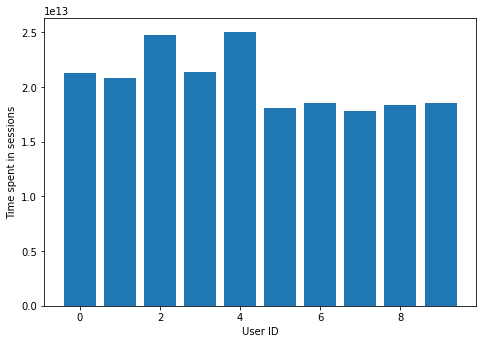

In [13]:
dropdown_timeframe_timespentsess = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_timespentsess = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_timespentsess = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_timespentsess(change):
    common_filtering_timespentsess(change.new, dropdown_user_timespentsess.value)

def dropdown_user_eventhandler_timespentsess(change):
    common_filtering_timespentsess(dropdown_timeframe_timespentsess.value, change.new)
    
def common_filtering_timespentsess(timeframe, user):
    output_widget_timespentsess.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_timespentsess:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.set_ylabel('Time spent in sessions')
        ax.set_xlabel('User ID')
        # ax.bar(df_processed_timeframed['userId'], df_processed_timeframed['duration'])
        display(ax.bar(df_processed_user_timeframed['userId'], df_processed_user_timeframed['duration']))

dropdown_timeframe_timespentsess.observe(dropdown_timeframe_eventhandler_timespentsess, names='value')
dropdown_user_timespentsess.observe(dropdown_user_eventhandler_timespentsess, names='value')
display(dropdown_timeframe_timespentsess)
display(dropdown_user_timespentsess)

In [14]:
display(output_widget_timespentsess)

Output()

## Show ratings of users


Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

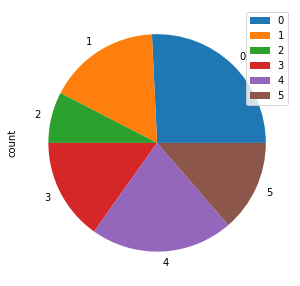

In [15]:
dropdown_timeframe_ratings = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_ratings = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_ratings = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_ratings(change):
    common_filtering_ratings(change.new, dropdown_user_ratings.value)

def dropdown_user_eventhandler_ratings(change):
    common_filtering_ratings(dropdown_timeframe_ratings.value, change.new)
    
def common_filtering_ratings(timeframe, user):
    output_widget_ratings.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_ratings:
        df_rating = df_user_timeframed.drop(df_user_timeframed[df_user_timeframed['type'] != "CORE_SCENE_RATE"].index)
        df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
        df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
        df_rating['rating_cat'] = [d['rating_cat'] for d in df_rating['data_str']]
        df_rating = df_rating.drop('data', axis=1)
        df_rating = df_rating.drop('data_str', axis=1)
        df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["rating"])['type']}).reset_index()
        df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
        df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
        df_rating_grouped.columns = ['rating', 'count']
        plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))
        display(plot)

dropdown_timeframe_ratings.observe(dropdown_timeframe_eventhandler_ratings, names='value')
dropdown_user_ratings.observe(dropdown_user_eventhandler_ratings, names='value')
display(dropdown_timeframe_ratings)
display(dropdown_user_ratings)

# Histograms

## Histogram showing concurrent users throughout an average day

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

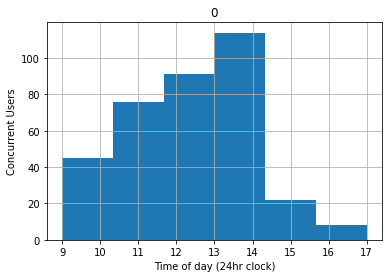

In [16]:
dropdown_timeframe_hist = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_hist = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_hist = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_hist(change):
    common_filtering_hist(change.new, dropdown_user_hist.value)

def dropdown_user_eventhandler_hist(change):
    common_filtering_hist(dropdown_timeframe_hist.value, change.new)
    
def get_times_active(row):
    end = row['time'].hour
    start = row['time'].hour - row['duration'].seconds//3600
    return_set = set()
    for i in range(end - start + 1):
        return_set.add(str(start + i))
    return return_set

def common_filtering_hist(timeframe, user):
    output_widget_hist.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_hist:
        df_processed_user_timeframed['hours_active'] = df_processed_user_timeframed.apply(get_times_active, axis=1) 
        df_pre_fri_hist = df_processed_user_timeframed.loc[df_processed_user_timeframed['weekday'] == 'Monday']
        
        data_for_hist = {}
            
        count = 0
        for times in df_pre_fri_hist['hours_active']:
            for time in times:
                data_for_hist[count] = float(time)
                count += 1

        df_fri_hist = pd.DataFrame(data_for_hist, index = [0])
        df_fri_hist = df_fri_hist.reindex(sorted(df_fri_hist.columns), axis=1)
        
        axarr = df_fri_hist.transpose().hist(bins=6)

        for ax in axarr.flatten():
            ax.set_xlabel("Time of day (24hr clock)")
            ax.set_ylabel("Concurrent Users")
        
        display(axarr)


dropdown_timeframe_hist.observe(dropdown_timeframe_eventhandler_hist, names='value')
dropdown_user_hist.observe(dropdown_user_eventhandler_hist, names='value')
display(dropdown_timeframe_hist)
display(dropdown_user_hist)

In [17]:
display(output_widget_hist)

Output()

## Histogram showing length of sessions

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

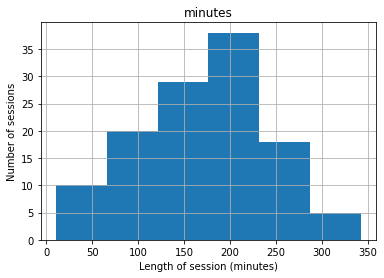

In [18]:
dropdown_timeframe_histsess = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_histsess = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_histsess = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_histsess(change):
    common_filtering_histsess(change.new, dropdown_user_histsess.value)

def dropdown_user_eventhandler_histsess(change):
    common_filtering_histsess(dropdown_timeframe_histsess.value, change.new)
    
def common_filtering_histsess(timeframe, user):
    output_widget_histsess.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_histsess:
        df_sesh_len_hist = df_processed_user_timeframed[['duration']].copy()
        df_sesh_len_hist['minutes'] = [d.total_seconds()/60 for d in df_processed_user_timeframed['duration']]
        df_min_hist = df_sesh_len_hist[['minutes']].copy()
        axarr = df_min_hist.hist(bins=6)

        for ax in axarr.flatten():
            ax.set_xlabel("Length of session (minutes)")
            ax.set_ylabel("Number of sessions")
        
        display(axarr)

dropdown_timeframe_histsess.observe(dropdown_timeframe_eventhandler_histsess, names='value')
dropdown_user_histsess.observe(dropdown_user_eventhandler_histsess, names='value')
display(dropdown_timeframe_histsess)
display(dropdown_user_histsess)

## Radar graph showing average ratings for each category

In [19]:
import ast

dropdown_timeframe_radarrating = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_radarrating = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_radarrating = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_radarrating(change):
    common_filtering_radarrating(change.new, dropdown_user_radarrating.value)

def dropdown_user_eventhandler_radarrating(change):
    common_filtering_radarrating(dropdown_timeframe_radarrating.value, change.new)
    
def common_filtering_radarrating(timeframe, user):
    output_widget_radarrating.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != int(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != int(user)].index)
    
    with output_widget_radarrating:
        df_rating = df_user_timeframed.drop(df_user_timeframed[df_user_timeframed['type'] != "CORE_SCENE_RATE"].index)
        df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
        df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
        df_rating['rating_cat'] = [d['rating_cat'] for d in df_rating['data_str']]
        df_rating = df_rating.drop('data', axis=1)
        df_rating = df_rating.drop('data_str', axis=1)
        df_rating_cat_grouped = pd.DataFrame({'mean' : df_rating.groupby(["rating_cat"])['rating'].mean()}).reset_index()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="polar")

        # theta has 5 different angles, and the first one repeated
        theta = np.arange(len(df_rating_cat_grouped) + 1) / float(len(df_rating_cat_grouped)) * 2 * np.pi
        # values has the 5 values from 'mean', with the first element repeated
        values = df_rating_cat_grouped['mean'].values
        values = np.append(values, values[0])

        # draw the polygon and the mark the points for each angle/value combination
        l1, = ax.plot(theta, values, color="C2", marker="o", label="Mean rating")
        plt.xticks(theta[:-1], df_rating_cat_grouped['rating_cat'], color='grey', size=12)
        ax.tick_params(pad=10) # to increase the distance of the labels to the plot
        # fill the area of the polygon with green and some transparency
        ax.fill(theta, values, 'green', alpha=0.1)

        # plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
        plt.title("Average Ratings for Different Categories")
        
        display(plt.show())

dropdown_timeframe_radarrating.observe(dropdown_timeframe_eventhandler_radarrating, names='value')
dropdown_user_radarrating.observe(dropdown_user_eventhandler_radarrating, names='value')
display(dropdown_timeframe_radarrating)
display(dropdown_user_radarrating)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='…

In [20]:
display(output_widget_radarrating)

Output()